#ESTRAZIONE PIXEL ART DA SCREENSHOT INSTAGRAM

In questo notebook svilupperò degli algoritmi di preparazione dei dati per il training. Siccome andrò ad utilizzare una rete CycleGAN, ci sarà bisogno di due set di immagini unpaired, uno appartenente al dominio A e uno appartenente al dominio B. 
Per un ciclo di training ho scelto di utilizzare come dominio B un set composto da immagini di pixel art costruito da me. 
Ho raccolto circa 1000 screenshot dall'app instagram sotto l'hashtag _#pixelart_
e creato un procedimento automatico di crop e resize dell'area di interesse da estrarre.




1.   Cropping da screenshot
2.   Square
3.   Ridimensionamento


In [1]:
import cv2
print('OpenCV version: ' + cv2.__version__)

from matplotlib import pyplot as plt

import numpy as np

OpenCV version: 4.1.2


In [2]:
!git clone https://github.com/felichan98/AISchools
import sys
sys.path.insert(0,'/content/AISchools')

Cloning into 'AISchools'...
remote: Enumerating objects: 19295, done.
remote: Counting objects: 100% (2511/2511), done.
remote: Compressing objects: 100% (2468/2468), done.
remote: Total 19295 (delta 45), reused 2503 (delta 40), pack-reused 16784
Receiving objects: 100% (19295/19295), 2.62 GiB | 34.21 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Checking out files: 100% (2594/2594), done.


Importo la directory, carico una lista di immagini in list_screenshots

(2300, 1080, 3)


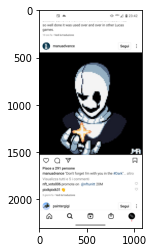

In [8]:
import os

directory = '/content/AISchools/PixelArt_Screenshot/'

#Preparo una lista di img di input raccolte dalla cartella PixelArt_Screenshot

list_screenshots = []

for filename in os.scandir(directory):
    if filename.is_file():
      path = directory + filename.name
      img = cv2.imread(path, cv2.IMREAD_COLOR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      list_screenshots.append(img)

#Prova
print(list_screenshots[4].shape)
plt.imshow(list_screenshots[4])


#Cropping

Ho bisogno di un algoritmo che riesca a tagliare l'immagine principale ed eliminare tutto ciò che c'è intorno. 
**Idea**: scansiono la foto in orizzontale e quando la riga non presenta più solamente bianchi allora inizia il contenuto di interesse.
Stessa cosa si può fare per trovare il punto di stop.


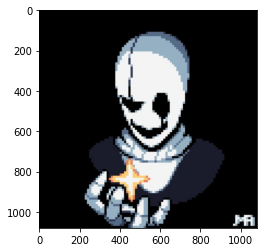

In [15]:
def crop_screenshot(img):
  start_index = 0
  started = False
  stop_index = 0

  for index, value in enumerate(img[:,0,:]):

    if(not started and np.all(img[index,:,:] < 253)):
      start_index = index
      started = True
      
    if(started and np.all(img[index,:,:]  >= 253)):
      stop_index = index
      break

  cropped_img = img[start_index + 1 : stop_index, :, :]

  #Se l'altezza della foto è troppo piccola è uno scarto, non la salvo
  if(cropped_img.shape[0] > 600):
    return cropped_img

cropped = crop_screenshot(list_screenshots[4])
plt.imshow(cropped)


#Square

Se la foto è rettangolare, viene resa quadrata mantenendo lo stesso centro.

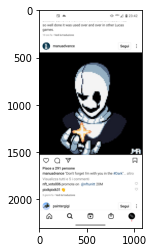

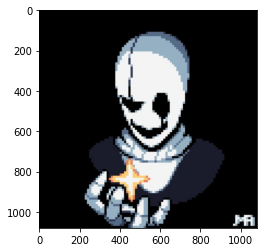

In [16]:
def square(img):
  if(img.shape[0] != img.shape[1]):
    max_dim = np.amax(img.shape[0:2])
    min_dim = np.amin(img.shape[0:2])
    center = max_dim // 2

    if(img.shape[0] == max_dim):
      img = img[center-min_dim//2:center+min_dim//2,:]

    if(img.shape[1] == max_dim):
      img = img[:,center-min_dim//2:center+min_dim//2]

  return img
    

test_img = list_screenshots[4]
plt.imshow(test_img)
plt.show()

squared = square(cropped)

plt.imshow(squared)
plt.show()



#Resize

Ridimensiono tutto a 256 x 256px

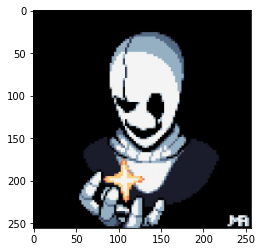

In [17]:
def resize(img, dim):
  img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST)
  return img_resized


dim = (256,256)

plt.imshow(resize(squared, dim))

#Intero processo

Uso le mie tre funzioni in sequenza per ottenere una cartella di output con immagini quadrate e ridimensionate da utilizzare per il training.


In [18]:
# Creo una cartella di output

out_path = '/content/AISchools/PixelArt_Cropped_Out/'

if not os.path.exists(out_path):
  os.makedirs(out_path)

for i in range(len(list_screenshots)):
  
  cropped_img = crop_screenshot(list_screenshots[i])
  if(cropped_img is not None):
    cropped_img = square(cropped_img)
  if(cropped_img is not None):
    cropped_img = resize(cropped_img, (256,256))
  filename = out_path + str(i) + '.png'

  if(cropped_img is not None):
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename, cropped_img)

Il codice sviluppato in questo notebook sarà usato nello script _dataset_extraction_pre_processing.py_ per processare l'intero dataset (1070 immagini). Nel git è presente una cartella di prova per questo notebook. L'intero dataset lo carico su drive.